In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sum_(x):
    sum_ = []
    for i in range(len(x)):
        sum_.append(sum(x[0:i]))
    return sum_

In [3]:
League = "PremierLeague"
df_ = pd.read_csv("C:\\Users\\Utilisateur\\Desktop\\Football_prediction\\"+(League)+"_statistics_full_data.csv")

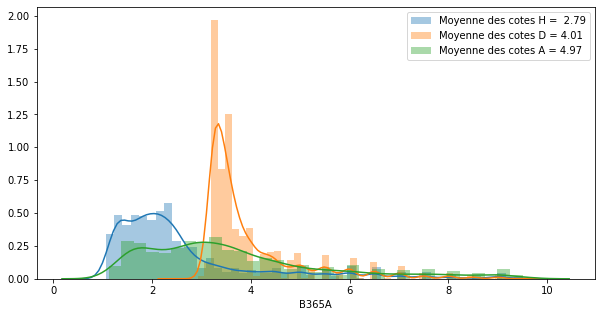

In [4]:
BH = df_.B365H.mean()
BD = df_.B365D.mean()
BA = df_.B365A.mean()

plt.figure(figsize=(10,5))
sns.distplot(df_.B365H.loc[df_.B365H <10], label = "Moyenne des cotes H =  %1.2f"%BH)
sns.distplot(df_.B365D.loc[df_.B365D <10], label = "Moyenne des cotes D = %1.2f"%BD)
sns.distplot(df_.B365A.loc[df_.B365A <10], label = "Moyenne des cotes A = %1.2f"%BA)
plt.legend()

In [5]:
log_b365DA = df_.B365D/df_.B365A
log_b365DH = df_.B365D/df_.B365H
df_["Log_B365DA"] = log_b365DA
df_["Log_B365DH"] = log_b365DH

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

list_drop = ["Gain_net", 'HomeTeam', 'AwayTeam',"Season", "FTR"]

Test = "Global" 
#Test = "Season"
odd_max = 10
odd_min = -10
N_season_split_train = 8

N_2019 = len(df_.loc[(df_.Season==2019)])
N_split_train_i = 0*38*10
N_split_train_f = (N_season_split_train)*38*10
N_split_test_i = (N_season_split_train)*38*10
N_split_test_f = (N_season_split_train+1)*38*10+N_2019

if Test == "Global":
    X = df_.loc[(df_.Log_B365 < odd_max) & (df_.Log_B365 > odd_min)].drop(["Gain_net_class"],axis=1)
    Y = df_.loc[(df_.Log_B365 < odd_max) & (df_.Log_B365 > odd_min)].Gain_net_class
    dict_y = {-1: 0, 1: 1}
    Y = Y.map(dict_y)
    X.fillna(value=0, inplace=True)
    X_sc = sc.fit_transform(X.drop(list_drop,axis=1))
    #feat = X.drop(list_drop,axis=1).columns.tolist()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)#, random_state=20)
    
elif Test == "Season":
    X = df_.loc[(df_.Log_B365 < odd_max) & (df_.Log_B365 > odd_min)].drop(["Gain_net_class"],axis=1)
    Y = df_.loc[(df_.Log_B365 < odd_max) & (df_.Log_B365 > odd_min)].Gain_net_class
    X.fillna(value=0, inplace=True)
    X_train = df_.iloc[N_split_train_i:N_split_train_f,:].loc[(df_.iloc[N_split_train_i:N_split_train_f,:].Log_B365 < odd_max) & (df_.iloc[N_split_train_i:N_split_train_f,:].Log_B365 > odd_min)].drop(["Gain_net_class"],axis=1)
    X_test = df_.iloc[N_split_test_i:N_split_test_f,:].loc[(df_.iloc[N_split_test_i:N_split_test_f,:].Log_B365 < odd_max) & (df_.iloc[N_split_test_i:N_split_test_f,:].Log_B365 > odd_min)].drop(["Gain_net_class"],axis=1)
    y_train = df_.iloc[N_split_train_i:N_split_train_f,:].loc[(df_.iloc[N_split_train_i:N_split_train_f,:].Log_B365 < odd_max) & (df_.iloc[N_split_train_i:N_split_train_f,:].Log_B365 > odd_min)].Gain_net_class
    y_test = df_.iloc[N_split_test_i:N_split_test_f,:].loc[(df_.iloc[N_split_test_i:N_split_test_f,:].Log_B365 < odd_max) & (df_.iloc[N_split_test_i:N_split_test_f,:].Log_B365 > odd_min)].Gain_net_class
    X_train.fillna(value=0, inplace=True)
    X_test.fillna(value=0, inplace=True)


ratio_odd = len(df_.loc[(df_.Log_B365 < odd_max) & (df_.Log_B365 > odd_min)])/len(df_)
print("Pourcentage de matchs sélectionnés par rapport à leur odds = ", ratio_odd)

Pourcentage de matchs sélectionnés par rapport à leur odds =  1.0


In [122]:
from sklearn.linear_model import LogisticRegression
             
logit = LogisticRegression(max_iter=5000, C=0.03, solver='liblinear', penalty='l1')
logit.fit(X_train.drop(list_drop,axis=1), y_train)
print("Train_score:", logit.score(X_train.drop(list_drop,axis=1), y_train), "Test_score:", logit.score(X_test.drop(list_drop,axis=1), y_test))

Train_score: 0.6665477888730386 Test_score: 0.6722539229671898


In [123]:
y_hat = logit.predict(X_test.drop(list_drop,axis=1))
y_hat_proba = logit.predict_proba(X_test.drop(list_drop,axis=1))


def betting_advice(y_hat, y_hat_proba, X_test, mise_max,):
    index_to_bet = []
    coeff_mise = []
    mise_max = mise_max #€
    
    for i in range(len(y_hat)):
        if y_hat[i] == 1:
            index_to_bet.append(i)
            coeff_mise.append(y_hat_proba[i][1])
    money_bet = np.asarray(coeff_mise)* mise_max
    feat_list = ['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'Journee', "Season"]
    Betting_advice = X_test.iloc[index_to_bet,:][feat_list]
    Betting_advice["ConfidenceIndex"] = coeff_mise
    Betting_advice["MoneyBetEuro"] = money_bet
    return Betting_advice

mise = 10
print("Ratio total de matchs à parier: ", ratio_odd*len(betting_advice(y_hat,y_hat_proba,X_test,mise))/len(X_test))
print("Nombre de matchs à parier: ", len(betting_advice(y_hat,y_hat_proba,X_test,mise)))
print("Matchs sur lesquels il faut parier une victoire de l'équipe à domicile:")
df_bet = betting_advice(y_hat,y_hat_proba,X_test,mise)
df_bet

Ratio total de matchs à parier:  0.4247503566333809
Nombre de matchs à parier:  1191
Matchs sur lesquels il faut parier une victoire de l'équipe à domicile:


,HomeTeam,AwayTeam,B365H,B365D,B365A,Journee,Season,ConfidenceIndex,MoneyBetEuro
4258,Southampton,Burnley,1.40,4.80,9.50,8,2016,0.716037,7.160368
3649,Southampton,Swansea,1.60,4.00,6.50,23,2014,0.604802,6.048019
1229,Newcastle,West Brom,1.83,3.50,4.50,9,2008,0.542537,5.425365
496,Wigan,Charlton,1.90,3.25,4.00,12,2006,0.504919,5.049189
1593,Everton,Stoke,1.57,4.00,6.00,8,2009,0.595567,5.955672
...,...,...,...,...,...,...,...,...,...
3350,Stoke,Hull,2.15,3.30,3.90,32,2013,0.528687,5.286872
3922,Man City,Liverpool,1.70,4.00,5.50,13,2015,0.572609,5.726088
1774,Arsenal,Sunderland,1.22,6.00,15.00,26,2009,0.827681,8.276809
1859,Fulham,Wolves,2.10,3.25,3.75,34,2009,0.566448,5.664482


In [10]:
df_tot = pd.concat((X_test,y_test),axis=1)
confidence = []
for i in range(len(y_hat_proba)):
    confidence.append(y_hat_proba[i][1])
conf = np.asarray(confidence).reshape(len(confidence),1)
df_tot = np.concatenate((df_tot.values,y_hat.reshape(y_hat.shape[0],1), conf),axis=1)

In [11]:
col_names = X_test.columns.tolist()
col_names.append(y_test.name)
col_names.append("y_hat")
col_names.append("ConfidenceIndex")
df__ = pd.DataFrame(data=df_tot, columns=col_names)

In [12]:
bins = [0,0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0,1,2,3,4,5]
df__['binned'] = pd.cut(df__['ConfidenceIndex'], bins=bins, labels=labels)

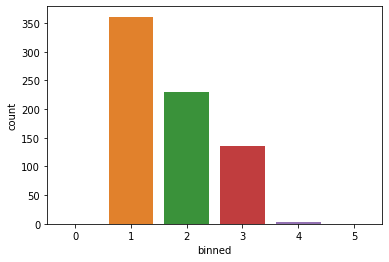

In [13]:
sns.countplot(df__['binned'].loc[df__.binned>0])

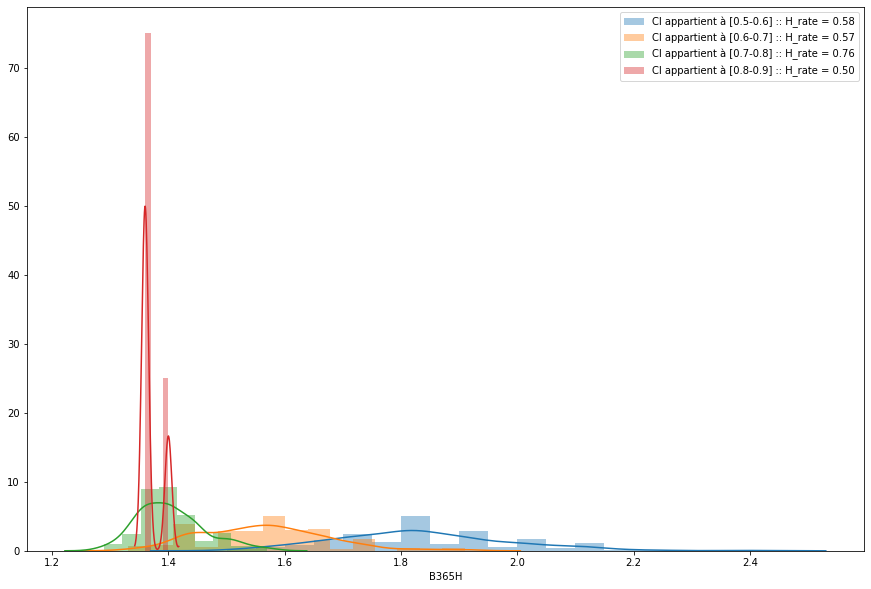

In [14]:
H_0 = df__.loc[(df__.binned == 0) & (df__.FTR == "H")].shape[0]/(df__.loc[(df__.binned == 0)].shape[0]+1e-9)
H_1 = df__.loc[(df__.binned == 1) & (df__.FTR == "H")].shape[0]/(df__.loc[(df__.binned == 1)].shape[0]+1e-9)
H_2 = df__.loc[(df__.binned == 2) & (df__.FTR == "H")].shape[0]/(df__.loc[(df__.binned == 2)].shape[0]+1e-9)
H_3 = df__.loc[(df__.binned == 3) & (df__.FTR == "H")].shape[0]/(df__.loc[(df__.binned == 3)].shape[0]+1e-9)
H_4 = df__.loc[(df__.binned == 4) & (df__.FTR == "H")].shape[0]/(df__.loc[(df__.binned == 4)].shape[0]+1e-9)

plt.figure(figsize=(15,10))
figure = plt.figure(1)
#sns.distplot(df__.loc[(df__.binned == 0), "B365H"], label="CI appartient à [0.0-0.5] :: H_rate = 0.36")
sns.distplot(df__.loc[(df__.binned == 1), "B365H"], label="CI appartient à [0.5-0.6] :: H_rate = %1.2f"%H_1)
sns.distplot(df__.loc[(df__.binned == 2), "B365H"], label="CI appartient à [0.6-0.7] :: H_rate = %1.2f"%H_2)
sns.distplot(df__.loc[(df__.binned == 3), "B365H"], label="CI appartient à [0.7-0.8] :: H_rate = %1.2f"%H_3)
sns.distplot(df__.loc[(df__.binned == 4), "B365H"], label="CI appartient à [0.8-0.9] :: H_rate = %1.2f"%H_4)
plt.legend()

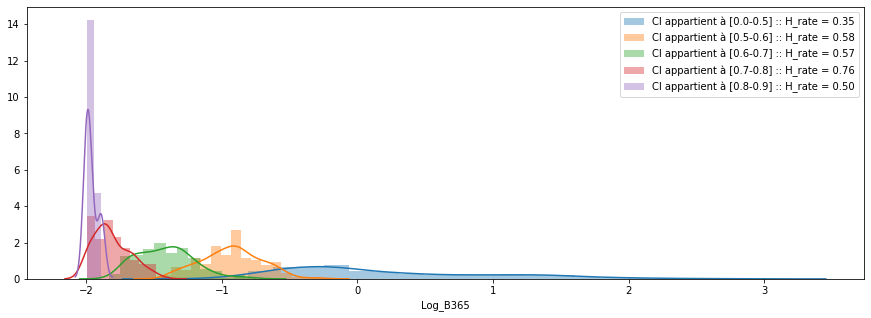

In [15]:
plt.figure(figsize=(15,5))
figure = plt.figure(1)
sns.distplot(df__.loc[(df__.binned == 0), "Log_B365"], label="CI appartient à [0.0-0.5] :: H_rate = %1.2f"%H_0)
sns.distplot(df__.loc[(df__.binned == 1), "Log_B365"], label="CI appartient à [0.5-0.6] :: H_rate = %1.2f"%H_1)
sns.distplot(df__.loc[(df__.binned == 2), "Log_B365"], label="CI appartient à [0.6-0.7] :: H_rate = %1.2f"%H_2)
sns.distplot(df__.loc[(df__.binned == 3), "Log_B365"], label="CI appartient à [0.7-0.8] :: H_rate = %1.2f"%H_3)
sns.distplot(df__.loc[(df__.binned == 4), "Log_B365"], label="CI appartient à [0.8-0.9] :: H_rate = %1.2f"%H_4)
plt.legend()

In [16]:
# Nombre de paris joués
# Played = 0 si on ne paris pas sur cette rencontre
# Played = 1 si on paris sur cette rencontre
played = []
for i in range(len(df__)):
    if (df__["y_hat"].iloc[i] == 1):
        played.append(1)
    else:
        played.append(0)
df__["Played"] = played

In [17]:
# Nombre de paris gagnants
# PlayWin = 1 si on paris sur cette rencontre ET que le paris est gagnant
# PlayWin = 0 si le paris n'est pas joué OU si le paris est perdant
PlayWin = []
for i in range(len(df__)):
    if ((df__["y_hat"].iloc[i] == 1) & (df__["FTR"].iloc[i] == "H")):
        PlayWin.append(1)
    else:
        PlayWin.append(0)
df__["PlayWin"] = PlayWin

In [18]:
# Nombre de paris joués par catégorie d'indice de confiance
for bin_value in np.arange(1,6,1):
    print("Nombre de paris joués par tranche de confiance ", bin_value, len(df__.loc[(df__.binned==bin_value) & (df__.Played==1)]))      

Nombre de paris joués par tranche de confiance  1 361
Nombre de paris joués par tranche de confiance  2 229
Nombre de paris joués par tranche de confiance  3 136
Nombre de paris joués par tranche de confiance  4 4
Nombre de paris joués par tranche de confiance  5 0


In [19]:
# Nombre de paris joués / Nombre de paris gagnants par catégorie d'indice de confiance
# Plus l'indice de confiance est élevé plus on joue
for bin_value in np.arange(2,6,1):
    print("Taux paris gagnants pour la tranche", bin_value, ":", len(df__.loc[(df__.binned==bin_value) & (df__.PlayWin==1)])/(len(df__.loc[(df__.binned==bin_value)])+1e-9))

Taux paris gagnants pour la tranche 2 : 0.5720524017442269
Taux paris gagnants pour la tranche 3 : 0.7647058823473184
Taux paris gagnants pour la tranche 4 : 0.499999999875
Taux paris gagnants pour la tranche 5 : 0.0


In [20]:
# Calcul du gain_net et du rendement par catégorie d'indice de confiance

for bin_value in np.arange(1,5,1):
    df_calcul = df__.loc[(df__.binned == bin_value)]
    gain_net_algo = []
    invest_algo = []
    ratio_bet = []
    bet = df_calcul["ConfidenceIndex"].values
    #bet = np.ones(len(df_calcul))
    
    for i in range(len(df_calcul)):
        if df_calcul["PlayWin"].iloc[i] == 1:
            invest_algo.append(mise*bet[i])
            gain_net_algo.append(df_calcul["B365H"].iloc[i]*(mise*bet[i])-(mise*bet[i]))
        elif df_calcul["PlayWin"].iloc[i] == 0:
            invest_algo.append(mise*bet[i])
            gain_net_algo.append(-mise*bet[i])

        elif df_calcul["Played"].iloc[i] == 0:
            gain_net_algo.append(0)
            invest_algo.append(0)
    print("Rendement pour la catégorie", bin_value,":",(np.asarray(sum_(gain_net_algo))/np.asarray(sum_(invest_algo)))[-1])

Rendement pour la catégorie 1 : 0.053506231619716245
Rendement pour la catégorie 2 : -0.10751707012431524
Rendement pour la catégorie 3 : 0.06917512013582944
Rendement pour la catégorie 4 : -0.5509458425881661


C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [124]:
"""Calcul du gain_net avec algo sur le TestSet"""
gain_net_algo = []
invest_algo = []

ratio_bet = []
for i in range(len(y_hat_proba)):
    ratio_bet.append(y_hat_proba[i][1])
new_bet = np.asarray(ratio_bet)


ratio = "Yes"
if ratio == "Yes":
    bet = 1./new_bet
elif ratio == "No":
    bet = np.ones(len(y_hat))
    
for i in range(len(y_test)):
    if (y_hat[i] == 1) :
        
        if (y_test.iloc[i] == 1):
            invest_algo.append(mise*bet[i])
            gain_net_algo.append(X_test["B365H"].iloc[i]*(mise*bet[i])-(mise*bet[i]))
            
            
        elif (y_test.iloc[i] == 0):
            invest_algo.append(mise*bet[i])
            gain_net_algo.append(-mise*bet[i])
            
    elif y_hat[i] == 0:
        invest_algo.append(0)
        gain_net_algo.append(0)

gain_net_no_algo = []

invest_no_algo =[]

for i in range(len(y_test)):
    invest_no_algo.append(mise)
    if y_test.iloc[i] == 1:
        gain_net_no_algo.append(X_test["B365H"].iloc[i]*mise -mise)
    else:
        gain_net_no_algo.append(-mise)
    
print("Investissement total (avec algo) = ", sum_(invest_algo)[-1])
print("Gain_net total (avec algo) = ", sum_(gain_net_algo)[-1])
print("Rendement total final (avec algo) = ", sum_(gain_net_algo)[-1]/(sum_(invest_algo)[-1]+1e-9))

Investissement total (avec algo) =  19027.395350329498
Gain_net total (avec algo) =  87.01654893321157
Rendement total final (avec algo) =  0.004573224413067137


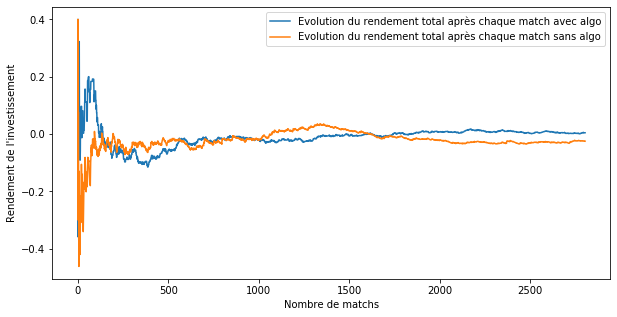

In [125]:
plt.figure(figsize=(10,5))
plt.plot(np.asarray(sum_(gain_net_algo))/(np.asarray(sum_(invest_algo))+1e-9), label= "Evolution du rendement total après chaque match avec algo")
plt.plot(np.asarray(sum_(gain_net_no_algo))/(np.asarray(sum_(invest_no_algo))+1e-9), label= "Evolution du rendement total après chaque match sans algo")
plt.xlabel("Nombre de matchs")
plt.ylabel("Rendement de l'investissement")
plt.legend()

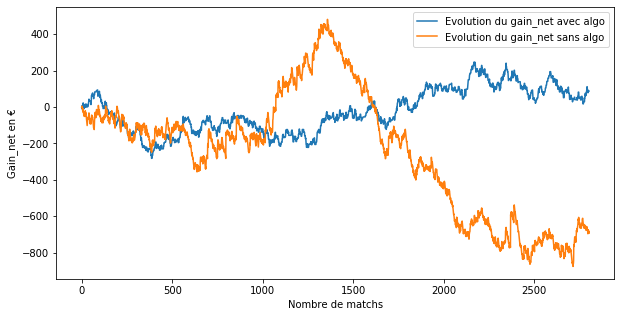

In [126]:
plt.figure(figsize=(10,5))
plt.plot(sum_(gain_net_algo), label= "Evolution du gain_net avec algo")
plt.plot(sum_(gain_net_no_algo), label= "Evolution du gain_net sans algo")
plt.xlabel("Nombre de matchs")
plt.ylabel("Gain_net en €")
plt.legend()

In [127]:
N_gain_positif = 0 # Nombre de paris rapportant de l'argent
N_gain_negatif = 0 # Nombre de paris faisant perdre de l'argent
for i in range(len(gain_net_algo)):
    if gain_net_algo[i]>0:
        N_gain_positif+=1
    elif gain_net_algo[i]<0:
        N_gain_negatif+=1
N_paris = N_gain_negatif + N_gain_positif # Nombre de paris joués
print("Taux de gains perdants =", N_gain_negatif/N_paris , "Taux de gains gagnants =", N_gain_positif/N_paris)

odds = [] # Cote des paris gagnants
for i in range(len(y_hat)):
    if (y_hat[i] == 1) & (y_test.iloc[i] == 1):
        odds.append(X_test.iloc[i,2])
print("Cote moyenne des paris gagnants: ", np.mean(odds))
print("Pour faire des bénéfices cette cote moyenne doit être supérieure ou égale à: ", N_paris/N_gain_positif)

Taux de gains perdants = 0.3501259445843829 Taux de gains gagnants = 0.6498740554156172
Cote moyenne des paris gagnants:  1.5405297157622737
Pour faire des bénéfices cette cote moyenne doit être supérieure ou égale à:  1.5387596899224807
